# Part 1 项目介绍

## 1.1 项目背景

**CIFAR-10** (Canadian Institute For Advanced Research) 是计算机视觉领域中最广泛使用的基准数据集之一，由 Alex Krizhevsky, Vinod Nair 和 Geoffrey Hinton 收集整理。该数据集包含 60,000 张 32x32 分辨率的彩色 RGB 图像，分为训练集 50,000 张和测试集 10,000 张。数据集共包含 10 个互斥的类别，每个类别有 6,000 张图像。这 10 个类别分别是飞机 (airplane)、汽车 (automobile)、鸟 (bird)、猫 (cat)、鹿 (deer)、狗 (dog)、青蛙 (frog)、马 (horse)、船 (ship) 和卡车 (truck)。由于图像分辨率较低，对于人类来说有时也难以区分，这使得它成为测试图像分类算法性能的理想数据集。

## 1.2 项目目标

本项目旨在深入探究和对比**传统机器学习方法**与现代**深度学习方法**在图像分类任务上的性能差异，从而理解计算机视觉技术的发展脉络。

首先，我们将建立一个基于传统方法的基准模型。这包括构建一个经典的图像分类流水线，使用 **HOG (方向梯度直方图)** 提取图像的纹理和形状特征，利用 **PCA (主成分分析)** 进行降维以减少计算量并去除噪声，最后使用 **SVM (支持向量机)** 作为分类器进行训练和预测。

其次，我们将探索作为当前最先进技术（SOTA）方向的深度学习方法。我们将构建一个端到端的 **卷积神经网络 (CNN)** 模型，利用卷积层自动学习从边缘到纹理再到物体部件的图像层级特征，并对比不同网络结构或超参数对性能的影响。

最后，我们将对两种方法进行全面的对比分析。我们将比较它们在测试集上的最终分类准确率，分析训练时间和推理时间的效率差异，并通过 t-SNE 可视化特征分布来直观展示特征提取的效果，从而深入理解深度学习相比传统方法的优势所在。

## 1.3 技术路线

本项目的实施将分为三个主要阶段，涵盖了从数据预处理到模型评估的完整流程。

**Step 1: 特征提取与可视化**。我们将首先进行数据的加载与归一化预处理，接着提取图像的 HOG 特征。随后，利用 PCA 将高维特征进行降维，其中保留 95% 方差的特征用于后续训练，而降至 2-3 维的特征则结合 t-SNE 算法进行数据分布的可视化分析，以观察类别的可分性。

**Step 2: 传统模型实验**。我们将基于 PCA 降维后的 HOG 特征来训练 SVM 分类器。在此过程中，我们将使用网格搜索或交叉验证等方法来寻找如 C 和 gamma 等最佳超参数，并最终评估 SVM 模型的准确率和混淆矩阵等性能指标。

**Step 3: 深度模型实验**。我们将搭建包含卷积层、池化层和全连接层的 CNN 网络架构，并配置交叉熵损失函数以及 Adam 或 SGD 优化器等训练策略。通过监控训练集与验证集的损失和准确率曲线来训练模型，最终评估 CNN 模型的表现，并将其与 SVM 的结果进行总结对比。

## 1.4 补充说明

![CIFAR-10](./resources/CIFAR-10-web.png)

我们使用Kaggle上的比赛数据集 [链接](https://www.kaggle.com/competitions/cifar-10/data?select=trainLabels.csv)，所有模型的结果将会在Kaggle上提交以获得实时分数反馈

我们建议使用`Anaconda`或者`miniconda`来管理虚拟环境：
```bash
conda create -n "CIFAR" python=3.9
conda activate CIFAR
pip install -r requirements.txt
```

**参考资料**：
1. [一文讲解方向梯度直方图（hog）](https://zhuanlan.zhihu.com/p/85829145)
2. [t-sne算法详解](https://blog.csdn.net/qq_44015059/article/details/106675444)
3. [深度学习（Deep Learning）全面详解：从原理到应用](https://blog.csdn.net/2403_89241132/article/details/151706234)

# Part 2 特征提取和降维

本部分将提取图像的HOG特征并进行降维处理，为后续的传统机器学习模型做准备。

## 2.1 特征提取

### 2.1.1 HOG特征介绍

**HOG (Histogram of Oriented Gradients)**，即方向梯度直方图，是一种在计算机视觉和图像处理中广泛使用的特征描述子，特别适用于物体检测任务。它通过计算和统计图像局部区域的梯度方向直方图来构成特征，能够很好地描述图像的边缘和形状信息。

HOG特征提取的核心思想在于，局部目标的表象和形状能够被梯度或边缘的方向密度分布很好地描述。首先，我们需要计算图像中每个像素点的梯度。对于图像 $I$ 中的像素点 $(x,y)$，其水平方向梯度 $G_x$ 和垂直方向梯度 $G_y$ 可以通过中心差分算子计算得到：

$$ G_x(x,y) = I(x+1, y) - I(x-1, y) $$
$$ G_y(x,y) = I(x, y+1) - I(x, y-1) $$

基于这两个分量，我们可以进一步计算该像素点的梯度幅值 $G(x,y)$ 和梯度方向 $\theta(x,y)$：

$$ G(x,y) = \sqrt{G_x(x,y)^2 + G_y(x,y)^2} $$
$$ \theta(x,y) = \arctan\left(\frac{G_y(x,y)}{G_x(x,y)}\right) $$

在获得像素级的梯度信息后，我们将图像划分为若干个小的空间区域，称为“单元格” (Cell)。在每个单元格内，我们统计梯度方向的直方图，将梯度方向分为若干个区间 (Bin)，并将像素的梯度幅值作为权重累加到对应的方向区间中。为了消除光照和阴影变化的影响，我们通常会将几个相邻的单元格组合成一个更大的“块” (Block)，并在块的范围内对特征向量进行归一化处理。

HOG特征具有显著的优点。由于它是基于局部梯度的统计信息，因此对图像的几何和光学形变保持了较好的不变性。特别是通过块归一化操作，它对光照变化表现出较强的鲁棒性，能够有效地捕捉物体的边缘轮廓信息，忽略无关的颜色或纹理细节。

我们在本次实验选择提取HOG特征，是因为HOG相比于其它的传统特征提取方法，更适合用于CIFAR任务中。这是由CIFAR图像的特点决定的。

**参数设置**:
- `orientations=9`: 梯度方向被分为9个bin
- `pixels_per_cell=(8, 8)`: 每个单元格为8x8像素
- `cells_per_block=(2, 2)`: 每个块包含2x2个单元格

如果需要找到最佳的参数提取组合，可能需要选择多种不同的参数。因为我们的传统方法主要作baseline使用，因此这里就尝试了一种组合

### 2.1.2 提取HOG特征

首先导入本部分必要的库(后续工作可以避免重复导入，仅导入新增的即可)

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage.feature import hog
from skimage import color
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42) # 设置随机种子以确保结果可复现

然后，我们简单地查看一下数据的类别分布等特征，并且挑选10条数据进行查看

In [2]:
# 加载训练数据标签
data_dir = 'Data/cifar-10' # 数据目录路径, 如果没有需要下载！
train_labels_df = pd.read_csv(os.path.join(data_dir, 'trainLabels.csv'))

print(f"训练集样本数: {len(train_labels_df)}")
print(f"类别分布:")
print(train_labels_df['label'].value_counts())
print(f"查看前5行数据:")
print(train_labels_df.head())

训练集样本数: 50000
类别分布:
label
frog          5000
truck         5000
deer          5000
automobile    5000
bird          5000
horse         5000
ship          5000
cat           5000
dog           5000
airplane      5000
Name: count, dtype: int64
查看前5行数据:
   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile


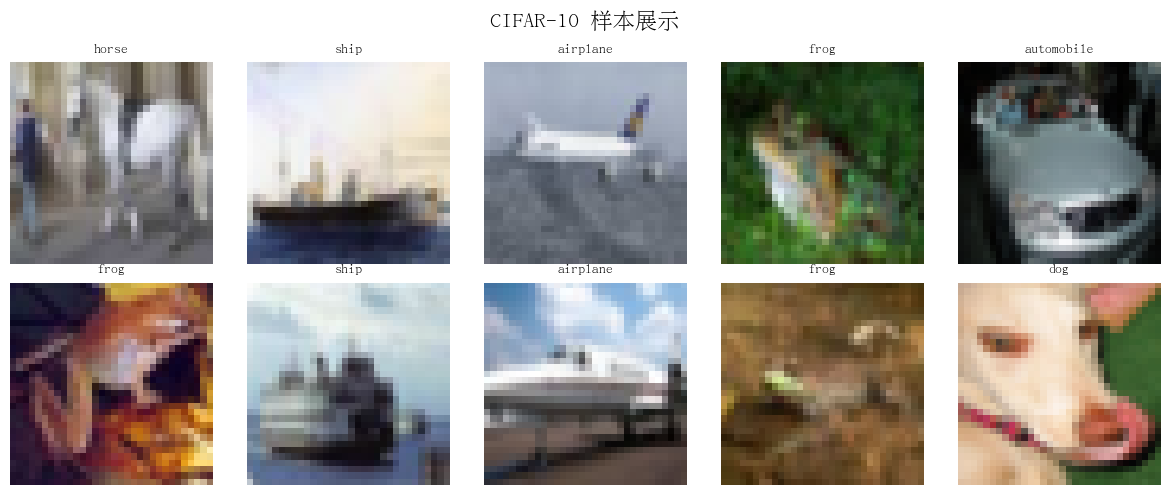

In [3]:
# 可视化部分样本
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAR-10 样本展示', fontsize=16)

# 随机选择10个样本
sample_ids = np.random.choice(train_labels_df['id'].values, 10, replace=False)

for idx, (ax, img_id) in enumerate(zip(axes.flatten(), sample_ids)):
    img_path = os.path.join(data_dir, 'train', f'{img_id}.png')
    img = Image.open(img_path)
    label = train_labels_df[train_labels_df['id'] == img_id]['label'].values[0]
    
    ax.imshow(img)
    ax.set_title(f'{label}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

下面这一部分，我们需要开始提取HOG特征。这一部分可以通过调用`skimage`包中的`hog()`函数实现

需要注意的是，因为原始图像是3通道的RGB图，我们需要先将图像转换为灰度图，再进行**HOG特征**提取
> 彩色图像也可以HOG特征提取，需要计算3次，然后选择3通道中梯度最大的那个。这里作灰度处理是为了降低计算量

In [4]:
# 定义HOG特征提取函数
def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    提取图像的HOG特征
    
    参数:
        image: RGB图像 (H, W, 3)
        orientations: 梯度方向的bin数量
        pixels_per_cell: 每个cell的像素大小
        cells_per_block: 每个block包含的cell数量
    
    返回:
        hog_features: HOG特征向量
    """
    # 将RGB图像转换为灰度图
    if len(image.shape) == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image
    
    # 提取HOG特征
    hog_features = hog(gray_image, 
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       visualize=False,
                       feature_vector=True)
    
    return hog_features

# 测试HOG特征提取
test_img_path = os.path.join(data_dir, 'train', '1.png')
test_img = np.array(Image.open(test_img_path))
test_hog = extract_hog_features(test_img)

print(f"原始图像形状: {test_img.shape}")
print(f"HOG特征维度: {test_hog.shape}")
print(f"HOG特征前10个值: {test_hog[:10]}")

原始图像形状: (32, 32, 3)
HOG特征维度: (324,)
HOG特征前10个值: [0.22663771 0.17619404 0.28460026 0.09246575 0.19104824 0.04217484
 0.00867563 0.03490412 0.0623346  0.14866002]


In [5]:
# 批量提取HOG特征
n_samples = 50000 # 这里直接用所有的样本

print(f"开始提取 {n_samples} 个样本的HOG特征...")

hog_features_list = []
labels_list = []

for i in range(n_samples):
    if (i + 1) % 5000 == 0:
        print(f"已处理: {i + 1}/{n_samples}")
    
    # 获取图像ID和标签
    img_id = train_labels_df.iloc[i]['id']
    label = train_labels_df.iloc[i]['label']
    
    # 加载图像
    img_path = os.path.join(data_dir, 'train', f'{img_id}.png')
    img = np.array(Image.open(img_path))
    
    # 提取HOG特征
    hog_feat = extract_hog_features(img)
    
    hog_features_list.append(hog_feat)
    labels_list.append(label)

# 转换为numpy数组
X_hog = np.array(hog_features_list)
y = np.array(labels_list)

print(f"特征提取完成!")
print(f"HOG特征矩阵形状: {X_hog.shape}")
print(f"标签数组形状: {y.shape}")
print(f"类别分布:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {label}: {count}")

开始提取 50000 个样本的HOG特征...
已处理: 5000/50000
已处理: 5000/50000
已处理: 10000/50000
已处理: 10000/50000
已处理: 15000/50000
已处理: 15000/50000
已处理: 20000/50000
已处理: 20000/50000
已处理: 25000/50000
已处理: 25000/50000
已处理: 30000/50000
已处理: 30000/50000
已处理: 35000/50000
已处理: 35000/50000
已处理: 40000/50000
已处理: 40000/50000
已处理: 45000/50000
已处理: 45000/50000
已处理: 50000/50000
特征提取完成!
HOG特征矩阵形状: (50000, 324)
标签数组形状: (50000,)
类别分布:
  airplane: 5000
  automobile: 5000
  bird: 5000
  cat: 5000
  deer: 5000
  dog: 5000
  frog: 5000
  horse: 5000
  ship: 5000
  truck: 5000
已处理: 50000/50000
特征提取完成!
HOG特征矩阵形状: (50000, 324)
标签数组形状: (50000,)
类别分布:
  airplane: 5000
  automobile: 5000
  bird: 5000
  cat: 5000
  deer: 5000
  dog: 5000
  frog: 5000
  horse: 5000
  ship: 5000
  truck: 5000


## 2.2 降维

本部分使用**PCA**进行降维,然后使用**t-SNE**进行可视化。可视化将会使用PCA降维到50维的预处理数据

### 2.2.1 PCA和t-SNE介绍

#### PCA (主成分分析)

**PCA (Principal Component Analysis)** 是一种经典的线性降维技术。它的核心目标是通过正交变换，将一组可能存在相关性的变量转换为一组线性不相关的变量，这些新的变量称为主成分。

从数学角度来看，PCA 试图找到数据方差最大的方向。假设我们将数据矩阵 $X$ 进行中心化处理，计算其协方差矩阵 $\Sigma$：
$$ \Sigma = \frac{1}{n-1} X^T X $$
通过对协方差矩阵进行特征分解 $\Sigma v = \lambda v$，我们可以得到特征值 $\lambda$ 和对应的特征向量 $v$。特征值的大小代表了数据在对应特征向量方向上的方差大小。我们将特征值按从大到小排序，选取前 $k$ 个特征值对应的特征向量组成投影矩阵 $W$，将原始数据 $X$ 映射到低维空间 $Y = XW$。

PCA 的优势在于计算效率高且无参数限制。它能够在大幅降低数据维度的同时，最大程度地保留原始数据的主要信息（方差），并有效地去除数据中的噪声和冗余。在本实验中，我们将 PCA 应用于两个场景：首先将 HOG 特征降维至 50 维以供 t-SNE 可视化使用；其次是保留 95% 的累计方差，生成紧凑的特征向量用于训练 SVM 分类器。

#### t-SNE (t分布随机邻域嵌入)

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** 是一种非线性降维算法，特别适用于将高维数据映射到 2D 或 3D 空间进行可视化。与 PCA 不同，t-SNE 侧重于保持数据的局部结构，即让高维空间中相似的点在低维空间中依然靠得很近。

t-SNE 的基本原理是将数据点之间的欧氏距离转化为条件概率来表示相似度。在高维空间中，使用高斯分布计算点 $x_i$ 和 $x_j$ 之间的相似度 $p_{ij}$；而在低维空间中，为了缓解**拥挤问题**，使用长尾的 t 分布（自由度为1）来计算对应点 $y_i$ 和 $y_j$ 的相似度 $q_{ij}$：
$$ q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}} $$
算法的目标是通过梯度下降法最小化两个分布之间的 Kullback-Leibler (KL) 散度：
$$ C = KL(P||Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}} $$

t-SNE 能够极其有效地揭示高维数据的聚类结构，展现出不同类别之间的边界。但需要注意的是，t-SNE 的计算复杂度较高，通常建议先使用 PCA 进行初步降维（如降至 50 维）以减少计算量。此外，t-SNE 的结果对随机初始化敏感，因此固定随机种子对于结果复现至关重要。

### 2.2.2 PCA降维

第一部分降维，需要将原始维度压缩到50维，然后用于t-SNE可视化

第二部分降维，需要将原始数据的信息保留$95\%$左右，然后用于Part 3 的SVM

下面进行第一部分的降维


降维后形状: (50000, 50)
保留总方差比例: 0.7291 (72.91%)
前10个主成分的方差比例: [0.10065912 0.0489324  0.03599448 0.03032671 0.02866752 0.0259715
 0.02255616 0.0218415  0.02070338 0.01998442]


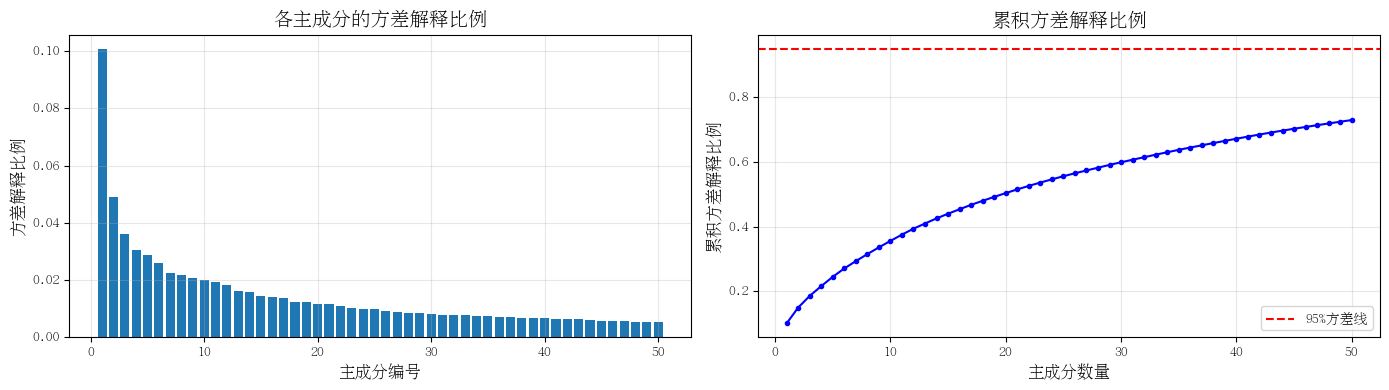

In [6]:
# 第一次PCA降维: 降到50维,用于t-SNE可视化
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X_hog)

# 计算解释的方差比例
explained_variance_ratio_50 = pca_50.explained_variance_ratio_
cumulative_variance_ratio_50 = np.cumsum(explained_variance_ratio_50)

print(f"\n降维后形状: {X_pca_50.shape}")
print(f"保留总方差比例: {cumulative_variance_ratio_50[-1]:.4f} ({cumulative_variance_ratio_50[-1]*100:.2f}%)")
print(f"前10个主成分的方差比例: {explained_variance_ratio_50[:10]}")

# 可视化方差解释比例
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# 单个主成分的方差比例
ax1.bar(range(1, 51), explained_variance_ratio_50)
ax1.set_xlabel('主成分编号')
ax1.set_ylabel('方差解释比例')
ax1.set_title('各主成分的方差解释比例')
ax1.grid(True, alpha=0.3)

# 累积方差解释比例
ax2.plot(range(1, 51), cumulative_variance_ratio_50, 'b-', marker='o', markersize=3)
ax2.set_xlabel('主成分数量')
ax2.set_ylabel('累积方差解释比例')
ax2.set_title('累积方差解释比例')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%方差线')
ax2.legend()

plt.tight_layout()
plt.show()

观察图像，我们可以发现：前4个主成分已经能解释超过20%的方差。后续随着主成分数量的增加，单个主成分解释的方差比例逐渐减小；右侧的图像则指出，如果想要保留95\%的信息，仅仅使用50个主成分还无法达到。这体现出图像识别任务中，选择特征的困难性。后续的对比实验可以发现，CNN不仅不需要手动选择特征，而且可以达到远超过传统特征选择方法的准确率。

下面进行第二部分的特征选择。

降维后的维度: 119
降维后的形状: (50000, 119)
保留的总方差比例: 0.9511 (95.11%)
维度压缩率: 0.3673 (36.73%)


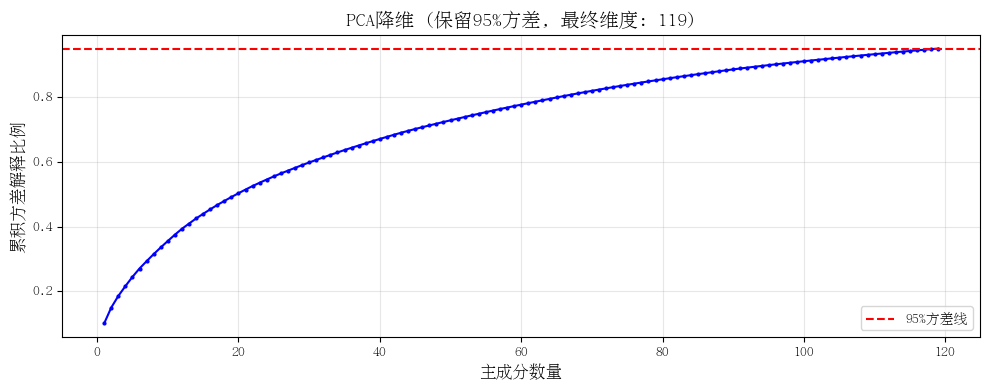


✓ PCA降维完成,数据已准备好用于后续的SVM分类器训练


In [7]:
# 第二次PCA降维: 保留95%的方差,用于SVM分类
pca_95 = PCA(n_components=0.95, random_state=42)
X_pca_95 = pca_95.fit_transform(X_hog)

# 计算解释的方差比例
explained_variance_ratio_95 = pca_95.explained_variance_ratio_
cumulative_variance_ratio_95 = np.cumsum(explained_variance_ratio_95)

print(f"降维后的维度: {X_pca_95.shape[1]}")
print(f"降维后的形状: {X_pca_95.shape}")
print(f"保留的总方差比例: {cumulative_variance_ratio_95[-1]:.4f} ({cumulative_variance_ratio_95[-1]*100:.2f}%)")
print(f"维度压缩率: {X_pca_95.shape[1] / X_hog.shape[1]:.4f} ({X_pca_95.shape[1] / X_hog.shape[1] * 100:.2f}%)")

# 可视化
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(cumulative_variance_ratio_95) + 1), cumulative_variance_ratio_95, 'b-', marker='o', markersize=2)
ax.set_xlabel('主成分数量')
ax.set_ylabel('累积方差解释比例')
ax.set_title(f'PCA降维 (保留95%方差, 最终维度: {X_pca_95.shape[1]})')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.95, color='r', linestyle='--', label='95%方差线')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\n✓ PCA降维完成,数据已准备好用于后续的SVM分类器训练")

### 2.2.3 t-SNE可视化

因为t-SNE需要的时间复杂度较高，因此，这里只选择了5k个样本进行可视化。正式实验将会使用所有样本。

In [8]:
# 使用t-SNE将50维数据降到2维进行可视化
n_tsne_samples = 5000  # 使用5000个样本进行t-SNE可视化

# 随机选择样本
np.random.seed(42)
indices = np.random.choice(len(X_pca_50), n_tsne_samples, replace=False)
X_tsne_input = X_pca_50[indices]
y_tsne = y[indices]

print(f"使用 {n_tsne_samples} 个样本进行t-SNE可视化")
print(f"输入数据形状: {X_tsne_input.shape}")

# 应用t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_input)

print(f"t-SNE降维后的形状: {X_tsne.shape}")

使用 5000 个样本进行t-SNE可视化
输入数据形状: (5000, 50)
t-SNE降维后的形状: (5000, 2)
t-SNE降维后的形状: (5000, 2)


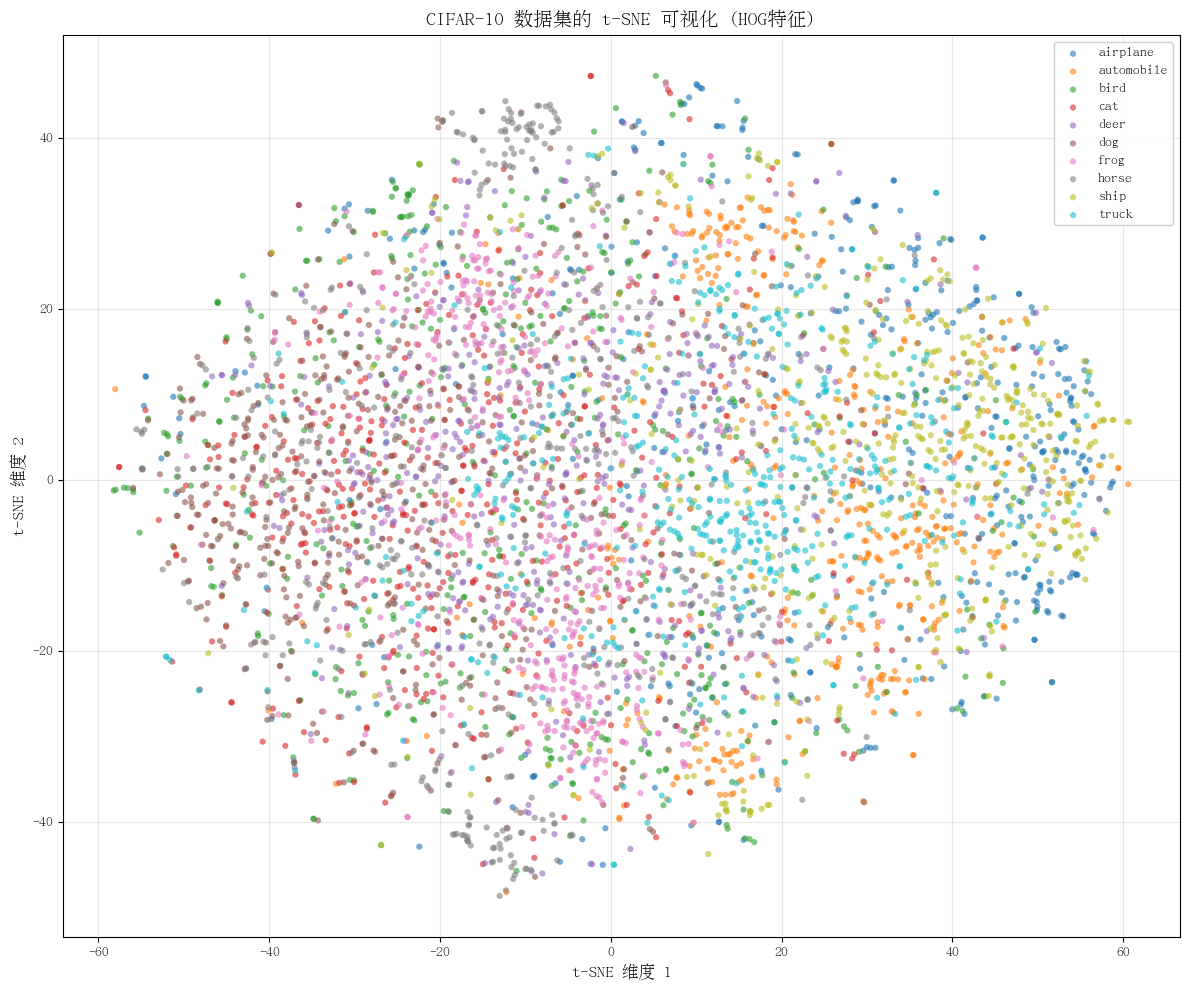

In [9]:
# 可视化t-SNE结果
fig, ax = plt.subplots(figsize=(12, 10))

# 定义颜色映射
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']
colors = plt.cm.tab10(np.linspace(0, 1, 10))
class_to_color = {cls: colors[i] for i, cls in enumerate(classes)}

# 绘制每个类别
for cls in classes:
    mask = y_tsne == cls
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
              c=[class_to_color[cls]], 
              label=cls, 
              alpha=0.6, 
              s=20,
              edgecolors='none')

ax.set_xlabel('t-SNE 维度 1', fontsize=12)
ax.set_ylabel('t-SNE 维度 2', fontsize=12)
ax.set_title('CIFAR-10 数据集的 t-SNE 可视化 (HOG特征)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

我们发现，尽管进行了t-sne可视化，但是图像依然很复杂，无法找到完全分离的簇。不过，我们仍然可以发现，红色(cat)和紫色(deer)的分布位置相近，墨绿色(ship)和天蓝色(airplane)的分布位置相近，并且这两对特征的分布有一定的距离。这说明PCA和t-sne进行一定程度上的特征分类。

# Part 3 传统模型实验

# Part 4 深度学习模型实验

## 4.1 深度学习简介
深度学习是机器学习的重要分支，其核心思想是利用多层神经网络（深度神经网络）模拟人类大脑的层级化信息处理机制，从海量数据中自动学习特征表示，实现分类、回归、生成等任务。与传统机器学习依赖人工设计特征不同，深度学习具有端到端学习能力，能够直接从原始数据中提取多层次特征，是当前人工智能技术的重要基础。

### 4.1.1 深度学习与传统机器学习的核心差异

传统机器学习方法（如 SVM、决策树）通常被称为浅层学习，其模型结构较为简单，一般只包含输入层与输出层，或至多拥有一层隐藏层。这类模型难以从原始数据中自动提取复杂的多层级特征，因此往往依赖人工设计特征，例如在图像处理中使用 HOG 手工提取边缘或纹理。

相比之下，深度学习依靠多层神经网络逐级抽象特征：底层通常学习边缘、颜色等低级属性，而更深的层能捕捉纹理、形状乃至语义等高级结构，实现从原始数据到最终任务的端到端学习。这种层次化表征能力使得深度学习能处理高维、非线性、复杂的数据结构，是其区别于传统机器学习的关键所在。

### 4.1.2 深度神经网络的基本构成
深度学习模型的基础是由大量神经元按层次连接形成的网络结构。网络中的神经元模拟“输入、加权求和、非线性变换”的计算过程。对一个神经元而言，其核心计算可以表示为：

$$ z = \sum_{i=1}^{n} w_i x_i + b $$

$$ a = f(z) $$

其中 $x_i$ 为输入，$w_i$ 和 $b$ 分别是权重和偏置，$f(\cdot)$ 为激活函数。激活函数引入非线性，使网络能够表示复杂的函数映射；若激活函数被移除，则多层网络将退化为线性模型，无法处理非线性问题。

深度神经网络一般由输入层、多个隐藏层和输出层构成。输入层负责接收原始数据，不进行计算；隐藏层承担特征抽象与表示学习的主要工作，层数越多，模型越能学习到更抽象的特征；输出层则根据具体任务生成分类概率或回归结果。

网络中可学习的变量称为参数，包括权重矩阵与偏置项，参数决定了模型的表达能力；而由人为设定的学习率、层数、batch size 等则属于超参数，它们影响训练过程与模型性能，需要根据任务进行调节。

### 4.1.3 深度学习的核心机制
深度学习模型的训练依赖损失函数、优化算法以及反向传播机制共同作用。

损失函数用于衡量模型输出与真实标签之间的差异，是优化的目标。例如分类任务常使用交叉熵损失：

$$ L = -\sum_{i=1}^{C} y_i \log \hat{y}_i $$

回归任务常使用均方误差：

$$ L = \frac{1}{N}\sum_{i=1}^{N}(y_i-\hat{y}_i)^2 $$

根据损失计算得到的梯度，优化器（如 SGD、Adam、RMSProp 等）会按梯度下降方向更新模型参数。以 SGD 为例，参数更新形式为：

$$ \theta^{(t+1)} = \theta^{(t)} - \eta \nabla_\theta L $$

其中 $\theta$ 为学习率。

梯度的计算依靠反向传播算法，其利用链式法则，将损失相对于输出层、隐藏层直至输入层各参数的偏导数逐层传播。训练过程在“前向计算网络输出—反向传播误差—更新参数”之间不断迭代，使模型逐渐逼近能够最小化损失的参数配置，从而完成学习任务。

## 4.2 数据预处理与可视化

在训练 CNN 模型之前，数据预处理是至关重要的一步。合理的归一化和标准化可以使得模型更快收敛、性能更稳定；而数据可视化不仅能帮助我们直观了解数据分布，还能及时发现异常样本。

### 4.2.1 归一化与标准化

In [ ]:
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 全局均值与方差
])

- ToTensor()：将 PIL 图像或 NumPy 数组转换为形状为 [C, H, W] 的浮点型张量，并将像素值归一化到 [0,1] 区间；
- Normalize()：对每个通道执行 (x - mean) / std，这些值是根据整个训练集计算得到的，全局标准化有助于梯度更稳定。

### 4.2.2 数据加载

In [ ]:
from torch.utils.data import DataLoader

train_dataset = datasets.CIFAR10(root='./Data', train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root='./Data', train=False, download=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False,num_workers=0)

- root：指定本地数据存储路径。例如 ./dataset 文件夹下会生成 MNIST 子目录；
- train：布尔值，True 表示加载训练集，False 表示加载测试集；
- download：布尔值，若本地 root 路径下不存在数据，则自动从网络下载(可能需要魔法上网)；若已下载可设为 False；
- shuffle：训练时打乱数据顺序，有助于打破样本间关联性，提升泛化；
- batch_size：每批次读取样本数，平衡训练稳定性和显存使用；
- num_workers：用于数据加载的子进程数量，可加速 I/O，但需与系统资源匹配。

### 4.2.3 样本可视化
在正式训练前，可视化部分样本以帮助我们确认标签是否正确、图像是否有噪声或畸变，以及预处理是否生效。

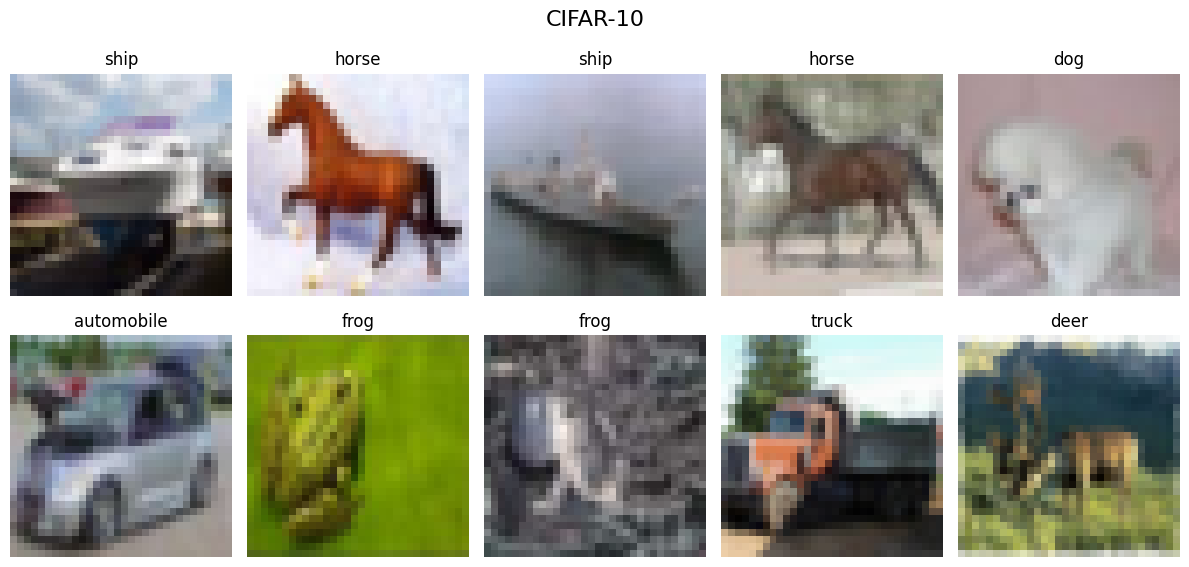

In [ ]:
import matplotlib.pyplot as plt

# 展示 10 个样本
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(12, 6))
for i in range(10):
    img = (images[i] * 0.5 + 0.5)  # 反归一化
    img = img.permute(1, 2, 0).numpy()  # CHW -> HWC

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis('off')

plt.suptitle("CIFAR-10", fontsize=16)
plt.tight_layout()
plt.show()

## 4.3 CNN 模型架构与实现

In [ ]:
import torch
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6,5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.net(x)
        return x

# 模型实例化与设备部署
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

- 卷积层 conv1：
    - nn.Conv2d(3, 6, 5)：输入为 3 通道彩色图像，使用 6 个 5×5 的卷积核进行特征提取；
    - nn.ReLU()：添加非线性激活函数，引入模型表达能力；
    - nn.MaxPool2d(2, 2)：使用 2×2 的池化窗口下采样，将图像尺寸从 32×32 缩小为14×14。

- 卷积层 conv2：
    - nn.Conv2d(6, 16, 5)：将前一层的 6 通道输出扩展为 16 个高层特征通道；
    - nn.ReLU()：继续添加非线性；
    - nn.MaxPool2d(2, 2)：再一次下采样，进一步降低空间维度。

- 全连接模块 fc：
    - nn.Flatten()：将 16 × 5 × 5 的三维张量展平成 400 维向量；
    - nn.Linear(400, 120)：第一层全连接层，映射到 120 维；
    - nn.ReLU()：继续使用 ReLU 激活；
    - nn.Linear(120, 84)：第二层全连接层，进一步学习紧凑表示；
    - nn.Linear(84, 10)：输出 10 维向量，每一维对应一个 CIFAR-10 类别的得分。

In [ ]:
from torchinfo import summary
summary(model, (64, 3, 32, 32))  # 使用 torchinfo 输出模型摘要

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           456
│    └─ReLU: 2-2                         [64, 6, 28, 28]           --
│    └─MaxPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─ReLU: 2-5                         [64, 16, 10, 10]          --
│    └─MaxPool2d: 2-6                    [64, 16, 5, 5]            --
│    └─Flatten: 2-7                      [64, 400]                 --
│    └─Linear: 2-8                       [64, 120]                 48,120
│    └─ReLU: 2-9                         [64, 120]                 --
│    └─Linear: 2-10                      [64, 84]                  10,164
│    └─ReLU: 2-11                        [64, 84]                  --
│  

## 4.4 模型训练

### 4.4.1 训练策略与超参数

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

- 损失函数：交叉熵损失是多分类任务的标准选择，可衡量模型输出的概率分布与真实标签分布之间的差异；
- 优化器：SGD具有良好的稳定性和可解释性，学习率 lr=0.01，momentum=0.9 能加速收敛并抑制震荡。

### 4.4.2 进行训练

In [ ]:
import os

def train(model, train_loader, criterion, optimizer, epoch):
    os.makedirs("checkpoints", exist_ok=True)  # 如果文件夹不存在，则创建
    model.train()
    for i in range(1, epoch+1):
        running_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (batch_idx+1) % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    i, batch_idx * len(inputs), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), running_loss / 100))
                running_loss = 0.0
        if i % 10 == 0:
            torch.save(model.state_dict(), './checkpoints/model_{}.pth'.format(i))
            print('Model saved as model_{}.pth'.format(i))

train(model, train_loader, criterion, optimizer, 50)

Train Epoch: 1 [12544/50000 (25%)]	Loss: 1.151145
Train Epoch: 1 [25344/50000 (51%)]	Loss: 1.144052
Train Epoch: 1 [38144/50000 (76%)]	Loss: 1.093622
Train Epoch: 2 [12544/50000 (25%)]	Loss: 0.946863
Train Epoch: 2 [25344/50000 (51%)]	Loss: 0.893414
Train Epoch: 2 [38144/50000 (76%)]	Loss: 0.861092
Train Epoch: 3 [12544/50000 (25%)]	Loss: 0.810056
Train Epoch: 3 [25344/50000 (51%)]	Loss: 0.781284
Train Epoch: 3 [38144/50000 (76%)]	Loss: 0.757719
Train Epoch: 4 [12544/50000 (25%)]	Loss: 0.731112
Train Epoch: 4 [25344/50000 (51%)]	Loss: 0.721855
Train Epoch: 4 [38144/50000 (76%)]	Loss: 0.699299
Train Epoch: 5 [12544/50000 (25%)]	Loss: 0.684722
Train Epoch: 5 [25344/50000 (51%)]	Loss: 0.669681
Train Epoch: 5 [38144/50000 (76%)]	Loss: 0.664237
Train Epoch: 6 [12544/50000 (25%)]	Loss: 0.637932
Train Epoch: 6 [25344/50000 (51%)]	Loss: 0.639787
Train Epoch: 6 [38144/50000 (76%)]	Loss: 0.638203
Train Epoch: 7 [12544/50000 (25%)]	Loss: 0.602176
Train Epoch: 7 [25344/50000 (51%)]	Loss: 0.596213


## 4.5 模型评估

### 4.5.1 准确率

In [ ]:
checkpoint_path = './checkpoints/model_50.pth'
try:
    model
except NameError:
    model = CNN().to(device)
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))

def test(model, test_loader):
    model.eval()
    class_correct = list(0. for _ in range(10))
    class_total = list(0. for _ in range(10))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {class_names[i]:5s} : {100 * class_correct[i]/class_total[i]:2.0f}%')
        else:
            print(f'Accuracy of {class_names[i]:5s} : N/A')

test(model, test_loader)

Accuracy of airplane : 63%
Accuracy of automobile : 74%
Accuracy of bird  : 46%
Accuracy of cat   : 47%
Accuracy of deer  : 62%
Accuracy of dog   : 53%
Accuracy of frog  : 70%
Accuracy of horse : 63%
Accuracy of ship  : 68%
Accuracy of truck : 75%


### 4.5.2 混淆矩阵与分类报告

              precision    recall  f1-score   support

    airplane       0.72      0.63      0.67      1000
  automobile       0.76      0.74      0.75      1000
        bird       0.54      0.46      0.49      1000
         cat       0.41      0.47      0.44      1000
        deer       0.53      0.62      0.57      1000
         dog       0.46      0.53      0.49      1000
        frog       0.72      0.70      0.71      1000
       horse       0.69      0.63      0.66      1000
        ship       0.79      0.68      0.73      1000
       truck       0.69      0.75      0.72      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000



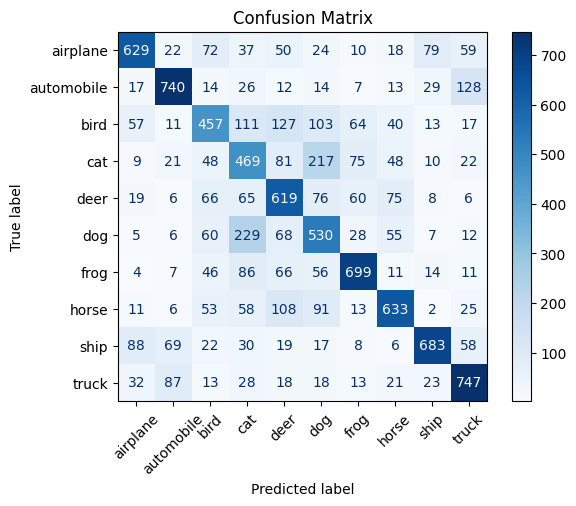

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1) 在 test 函数里收集
y_trues, y_preds = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu()
        y_preds.extend(preds.numpy())
        y_trues.extend(y.numpy())

# 2) 计算并打印报告
print(classification_report(y_trues, y_preds, target_names=class_names))

# 3) 混淆矩阵
cm = confusion_matrix(y_trues, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

### 4.5.3 ROC曲线图

采用 One-vs-Rest 方法，对每个类分别绘制 ROC 曲线。

AUC 越高，说明该类的分类能力越强。

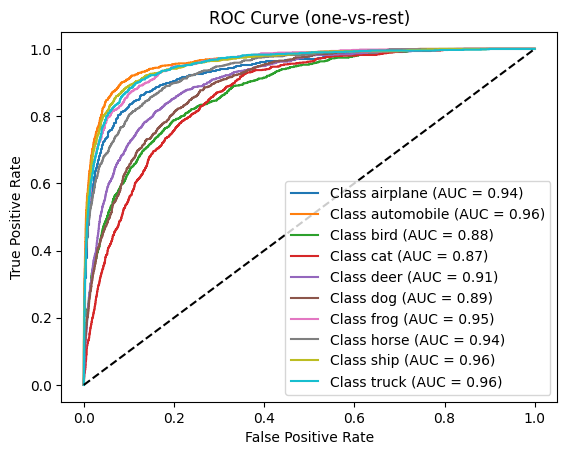

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 10
y_trues_bin = label_binarize(y_trues, classes=list(range(n_classes)))
y_scores = []  # 用 softmax 后的概率

model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        logits = model(x)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        y_scores.append(probs)
y_scores = np.vstack(y_scores)

# 针对每一类画 ROC
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_trues_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (one-vs-rest)')
plt.legend(loc='lower right')
plt.show()

### 4.5.4 Kaggle提交结果

In [ ]:
import os
import pandas as pd
from PIL import Image

test_dir = './Data/cifar-10/test/test'
output_csv = 'submission.csv'

files = [f for f in os.listdir(test_dir) if f.lower().endswith('.png')]
def file_id(fname):
    return int(os.path.splitext(fname)[0])
files = sorted(files, key=file_id)

ids = []
labels = []

model.eval()
with torch.no_grad():
    for fname in files:
        img_id = file_id(fname)
        img_path = os.path.join(test_dir, fname)
        img = Image.open(img_path).convert('RGB')
        inp = transform(img).unsqueeze(0).to(device)
        logits = model(inp)
        pred = logits.argmax(dim=1).item()
        ids.append(img_id)
        labels.append(class_names[pred])

df_sub = pd.DataFrame({'id': ids, 'label': labels})
df_sub = df_sub.sort_values('id')
df_sub.to_csv(output_csv, index=False)
print(f"Saved predictions to {output_csv} ({len(df_sub)} rows).")

最终在Kaggle上提交的得分为0.62050，排名为79/232。

![Kaggle提交结果](./resources/CIFAR-10_Result_DeepLearning.png)

# Part 5 总结